# Cluster analysis of SDMoA paintings

## Importing stuff

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from itertools import cycle #for plotting clusters
import seaborn as sns
sns.set()
from sklearn.cluster import AffinityPropagation, KMeans
from sklearn import metrics
from sklearn.manifold import TSNE 
from sklearn import preprocessing

In [3]:
#import matrix of average emotion scores for each painting as a pandas df
aveEmotionsMATLAB = pd.read_csv("aveEmotion.csv");
#aveEmotionsMATLAB.head(5)

In [4]:
#import all rating data
ratingData = np.empty((109, 10, 21))

for i in range(1,22):
    ratingData[:,:,i-1] = pd.read_excel("ratingData-sorted.xlsx", sheet_name=i, usecols=range(3,13))

In [5]:
#check to make sure the order of paintings is the same for all subjects
for i in range(0,21):
    print((ratingData[:,0,i] == ratingData[:,0,0]).all())
#ratingData[:,0,:]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


## An exploration in normalization...

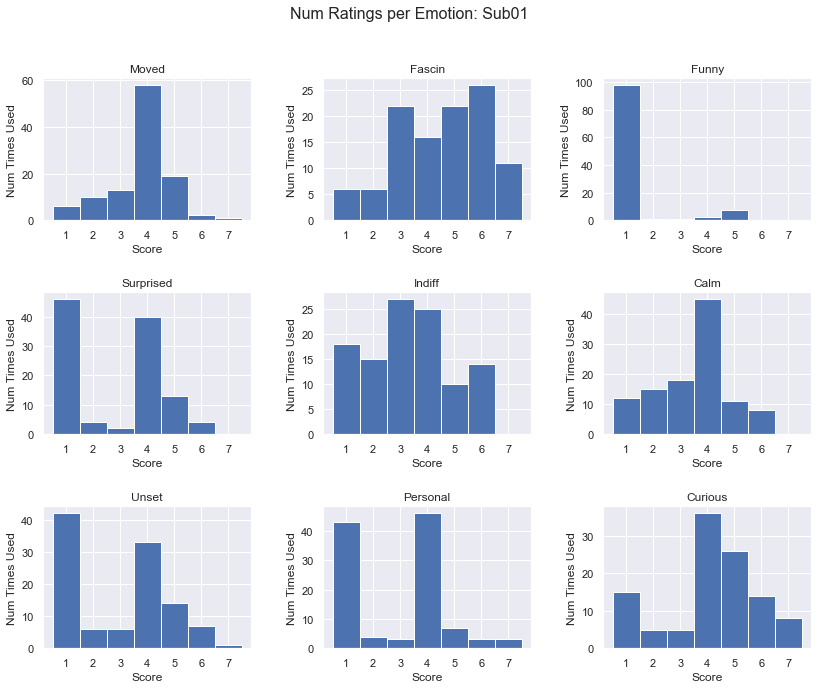

In [92]:
#histograms of scores for each emotion for sub01 (pre-normalizing)

fig, axes = plt.subplots(nrows=3, ncols=3, sharey = True, sharex = True, figsize=(12,10))

#plt.setp(axes, xticks=[1,2,3,4,5,6,7]) 
emotionList=["Moved","Fascin","Funny","Surprised","Indiff","Calm","Unset","Personal","Curious"]
fig.suptitle("Num Ratings per Emotion: Sub01", size=16)

dim=331
for i in range(1,10):
    plt.subplot(dim+(i-1), \
                      xlabel="Score", ylabel="Num Times Used",\
                      xticks=np.arange(1,8,1)
                     )
    plt.hist(ratingData[:,i,0], range=[1, 8], bins=7, align='left')
    plt.title(emotionList[i-1])
                  
plt.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.88)

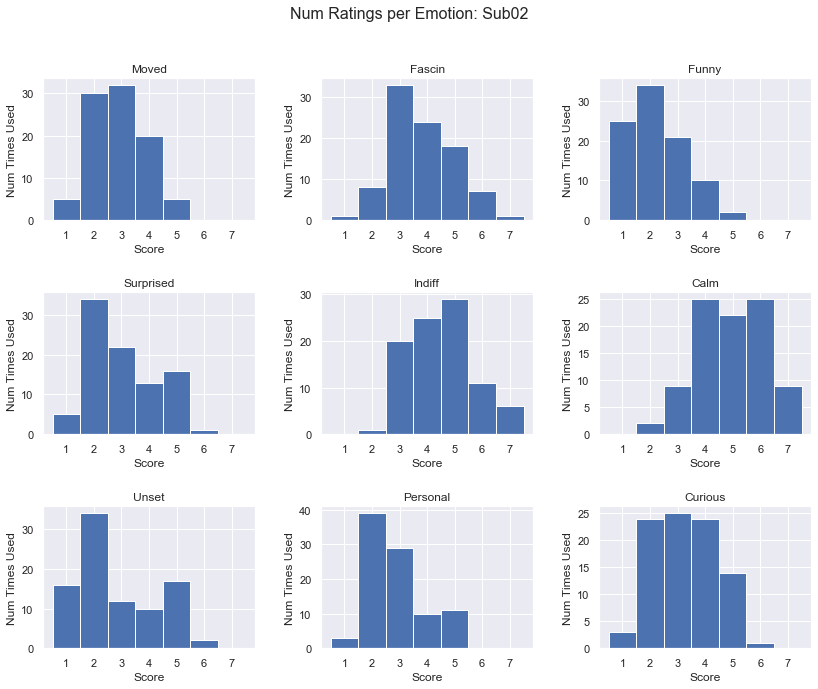

In [93]:
#histogram of average Moved score for sub02

fig, axes = plt.subplots(nrows=3, ncols=3, sharey = True, sharex = True, figsize=(12,10))

emotionList=["Moved","Fascin","Funny","Surprised","Indiff","Calm","Unset","Personal","Curious"]
fig.suptitle("Num Ratings per Emotion: Sub02", size=16)

dim=331
for i in range(1,10):
    plt.subplot(dim+(i-1), \
                      xlabel="Score", ylabel="Num Times Used",\
                      xticks=np.arange(1,8,1)
                     )
    plt.hist(ratingData[:,i,1], range=[1, 8], bins=7, align='left')
    plt.title(emotionList[i-1])
                  
plt.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.88)

Different emotions have really different distributions, even within a subject, so I definitely agree that we should standardize per subject & emotion rather than just subject.

In [54]:
#standardize data per person per emotion (find mean, find sd, substract mean and divide by sd)
standardRating = np.copy(ratingData)

for i in range(0,20): #per subject
    for j in range(1,10): #per emotion
        standardRating[:,j,i] = preprocessing.scale(ratingData[:,j,i])

In [55]:
#just making sure this^ did something
print(ratingData[0,:,0])
print(standardRating[0,:,0])

[1.001e+03 4.000e+00 5.000e+00 1.000e+00 1.000e+00 4.000e+00 5.000e+00
 1.000e+00 5.000e+00 2.000e+00]
[ 1.00100000e+03  2.04383195e-01  3.00000000e-01 -3.20277304e-01
 -1.08274325e+00  4.28626422e-01  1.12656998e+00 -1.10861485e+00
  1.20744681e+00 -1.28173825e+00]


I also tried computing this without using the preprocessing module, just to double check it was doing the same thing and indeed it was! But there was an error: RuntimeWarning: invalid value encountered in double_scalars so I'm using the preprocessing. This was the other version:  

In [40]:
#standardRatingByHand = np.copy(ratingData)

#for i in range(0,20):
    #for j in range(0,9):
        #mean = np.nanmean(standardRatingByHand[:,j,i])
        #sd = np.nanstd(standardRatingByHand[:,j,i])
        #for k in range(0,109):
            #standardRatingByHand[k,j,i] = (standardRatingByHand[k,j,i]-mean)/sd

# np.allclose(standardRating,standardRatingByHand, equal_nan=True) --> this outputs True

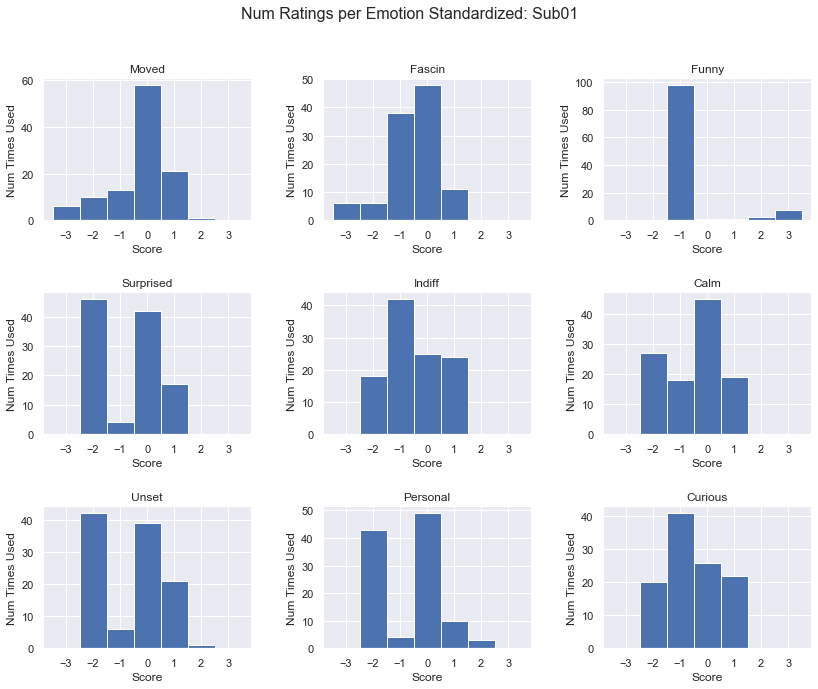

In [94]:
#histogram of average scores for each emotin for sub01 - post-standarizing
fig, axes = plt.subplots(nrows=3, ncols=3, sharey = True, sharex = True, figsize=(12,10))

emotionList=["Moved","Fascin","Funny","Surprised","Indiff","Calm","Unset","Personal","Curious"]
fig.suptitle("Num Ratings per Emotion Standardized: Sub01", size=16)

dim=331
for i in range(1,10):
    #xmin, xmax = min(standardRating[:,i,0]), max(standardRating[:,i,0])
    plt.subplot(dim+(i-1), \
                      xlabel="Score", ylabel="Num Times Used",\
                    xticks=np.arange(-3, 4, 1)
                     )
    plt.hist(standardRating[:,i,0], bins=7, range=[-3.0, 4.0], align='left')
    plt.title(emotionList[i-1])
                  
plt.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.88)

# for i in range(0,9):
#     plt.subplot(dim+i)
#     plt.hist(standardRating[:,i+1,0], bins=7)
#     plt.title(emotionList[i])
    
# plt.tight_layout()
# fig.subplots_adjust(top=0.88)



### Looks like this didn't change the distribution at all? Might be a visualization issue on my end though. I was having trouble with this graphs >:(

Robert: I don't think we would expect this to change the distribution, if we are still using the same number of bins (7) with equal spacing. The scores have changed though, are now seen in standard units. (0 is mean, +/- vals are multiples of std. dev.)

### : )

In [ ]:
#This is what I did before - can ignore
#standardRating = ratingData

#for i in range(0,20):
    #standardRating[:,:,i] = preprocessing.scale(ratingData[:,:,i], axis=1)
    
#print(standardRating[:,:,20])

Recreating the matrix of averages

In [95]:
# means of each painting's emotion
aveEmotionsCopy = standardRating.copy()
aveEmotions = aveEmotionsCopy[:,:,1]

for i in range(0,109):
    for j in range(1,10):
        aveEmotions[i,j] = np.nanmean(aveEmotionsCopy[i,j,:])

In [101]:
# turing aveEmotions into a df
aECols = ['ID','Moved','Fascinated','Funny','Surprised','Indifferent','Calm','Unsettling','Personal','Curious']
aveEmotions = pd.DataFrame(data=aveEmotions, columns=aECols)
aveEmotions.head(10)

,ID,Moved,Fascinated,Funny,Surprised,Indifferent,Calm,Unsettling,Personal,Curious
0,1001.0,0.055470,0.539793,-0.064899,0.359758,0.021301,0.302132,-0.053292,0.528519,0.487520
1,1002.0,-0.169808,-0.102406,0.935254,0.296957,0.517164,0.760554,-0.330602,0.151187,-0.121077
2,1003.0,0.110177,0.052632,-0.110637,0.125753,0.293006,0.560921,-0.119360,0.530289,0.076214
3,1004.0,0.676105,0.365665,-0.356315,-0.138310,-0.299066,1.280370,-0.594691,0.445455,0.378468
4,1005.0,-0.819067,0.223562,1.482217,0.626807,0.509202,-0.070669,0.327951,-0.358358,0.388488
5,1006.0,-0.605781,-0.398667,-0.007742,-0.161781,0.791667,-0.005937,-0.094401,-0.546196,-0.250616
6,1007.0,0.326431,0.375793,-0.261574,0.394683,-0.190735,0.909559,-0.431250,0.643413,0.246484
7,1008.0,-0.055526,0.144564,-0.100754,0.103671,0.753893,0.066126,0.106312,-0.276569,-0.085208
8,1009.0,0.297149,0.608318,0.161487,0.302879,-0.405464,0.603738,0.293114,0.504394,0.673587
9,1010.0,0.397693,0.754296,0.050886,0.199996,-0.235692,0.180377,-0.397177,0.676866,0.492395


### Variability

In [102]:
# create matrix of variance scores for each painting
# not using this for anything - just wanted to see what it looked like. Overall, pretty uniform, with a few exceptions.
varsPerPainting = np.zeros(109)

for i in range(0,109):
    varsPerPainting[i] = np.nanvar(standardRating[i,1:10,:])
    
varsPerPainting = pd.DataFrame(data=varsPerPainting, columns=['Universal Var'])
varsPerPainting.head(10)

,Universal Var
0,1.702009
1,1.710756
2,1.305685
3,1.472761
4,1.952177
5,1.969290
6,1.288078
7,1.470936
8,1.025884
9,1.237239


In [103]:
#create matrix of variance scores for each emotional dimension per painting
varsPerEmotionCopy = standardRating.copy()
varsPerEmotion = varsPerEmotionCopy[:,:,1]

for i in range(0,109):
    for j in range(1,10):
        varsPerEmotion[i,j] = np.nanvar(varsPerEmotionCopy[i,j,:])
        
varCols = ['ID','Moved Var','Fascin Var','Funny Var','Surp Var','Indiff Var','Unset Var','Calm Var','Personal Var','Curious Var']
varsPerEmotion = pd.DataFrame(data=varsPerEmotion, columns=varCols)
#adding the total variance because I can
varsPerEmotion = varsPerEmotion.join(varsPerPainting)
varsPerEmotion.head(10)

,ID,Moved Var,Fascin Var,Funny Var,Surp Var,Indiff Var,Unset Var,Calm Var,Personal Var,Curious Var,Universal Var
0,1001.0,1.469095,2.705098,0.434023,2.345384,1.123710,2.607894,0.545858,1.173602,2.399997,1.702009
1,1002.0,1.089603,1.207971,1.079433,1.544642,2.720036,3.344687,0.935159,0.987593,0.909742,1.710756
2,1003.0,0.757121,0.776568,0.366995,0.688864,3.120077,3.108315,1.008598,0.502257,0.934030,1.305685
3,1004.0,1.068954,1.856642,0.471329,0.678363,1.408542,1.739413,0.521262,1.146397,1.551546,1.472761
4,1005.0,0.703871,2.770416,1.192220,1.865725,1.055493,2.525433,0.710057,0.928565,2.474610,1.952177
5,1006.0,1.054226,2.646811,0.652478,2.344780,1.917509,3.072568,1.172885,0.838736,2.656543,1.969290
6,1007.0,0.813634,1.580131,0.420325,1.536955,0.685847,2.949345,0.539474,0.919258,0.586403,1.288078
7,1008.0,0.812552,1.147625,0.604931,1.370797,3.237464,1.124191,1.813613,1.167296,1.295181,1.470936
8,1009.0,0.991774,1.128164,0.371438,0.781722,0.405380,1.024036,0.854010,0.638591,2.168337,1.025884
9,1010.0,0.751950,1.732036,0.587934,0.674827,0.598062,2.533620,0.393952,0.587730,2.058105,1.237239


In [104]:
#create aveEmotions copy without ID column to be used for clustering

X = aveEmotions.drop(['ID'],axis=1)
X = X.to_numpy()

#X = np.delete(aveEmotions, 0, axis=1) # <-- can't remember what this does but it was there last time so.....
#print(X[:10]) # first ten rows

In [105]:
X

array([[ 5.54695843e-02,  5.39793037e-01, -6.48988157e-02,
         3.59758438e-01,  2.13013730e-02,  3.02131770e-01,
        -5.32916140e-02,  5.28518671e-01,  4.87520484e-01],
       [-1.69808002e-01, -1.02406493e-01,  9.35253591e-01,
         2.96956576e-01,  5.17164439e-01,  7.60554043e-01,
        -3.30601551e-01,  1.51187500e-01, -1.21076582e-01],
       [ 1.10176723e-01,  5.26322542e-02, -1.10637311e-01,
         1.25753210e-01,  2.93006179e-01,  5.60921011e-01,
        -1.19360006e-01,  5.30288874e-01,  7.62143724e-02],
       [ 6.76105485e-01,  3.65665478e-01, -3.56315287e-01,
        -1.38309525e-01, -2.99065692e-01,  1.28037000e+00,
        -5.94690838e-01,  4.45454813e-01,  3.78467880e-01],
       [-8.19067231e-01,  2.23561968e-01,  1.48221723e+00,
         6.26806544e-01,  5.09202453e-01, -7.06690566e-02,
         3.27951166e-01, -3.58358209e-01,  3.88488426e-01],
       [-6.05780531e-01, -3.98666937e-01, -7.74223985e-03,
        -1.61781471e-01,  7.91666906e-01, -5.936542

### Dimensional Reduction (t-SNE)

So we can plot our 9-dim data in 2-d.

Sydney: I set perplexity to 20, which is kind of an arbitrary number, since I think that's around the average number of paintings in each gallery....

Robert: I played around and settled on 30. but you're right the choice is arbitrary.

See Notes on t-SNE: [https://distill.pub/2016/misread-tsne/](https://distill.pub/2016/misread-tsne/)

In [106]:
# choice of perplexity is subjective, until you see a good layout/separation
# tsne = TSNE(n_components=2, perplexity = 20, random_state = 0) 

tsne = TSNE(n_components=2, perplexity = 30, random_state = 0) 

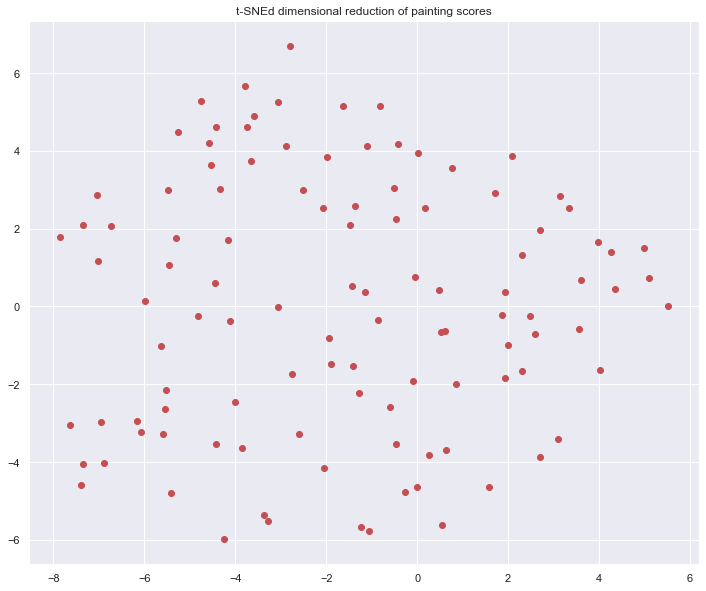

In [137]:
# tSNE performed on aveEmotions data

X_tsned = tsne.fit_transform(X)

plt.figure(figsize=(12, 10))
tsned = plt.scatter(X_tsned[:,0],X_tsned[:,1],c='r')
plt.title('t-SNEd dimensional reduction of painting scores')
plt.show()

__NOTE__: UMAP is another dimensional reduction technique we could explore. 

- https://umap-learn.readthedocs.io/en/latest/
- https://arxiv.org/abs/1802.03426

Would have to look into whether it is appropriate for our use case.

## Clustering time!

### shared clustering code and helper functions

In [164]:
af = AffinityPropagation()

ratings = np.array([1,2,3,4,5,6,7,8,9])

# function to get a table of the amount of paintings in each cluster
#whichCluster is a string
def amountInCluster(whichCluster,numClusters):
    clusterList = list(range(0,numClusters,1))
    clusterAmount = list(range(0,numClusters,1))

    for i in range(0,numClusters):
        clusterAmount[i] = aveEmotions[whichCluster][(aveEmotions[whichCluster] == i)].count()
    
    clusterDict = {'Cluster': clusterList, 'numItems': clusterAmount}
    clusterAmounts = pd.DataFrame.from_dict(clusterDict)
    
    return clusterAmounts

# function to get col means for each cluster

#whichCluster is a str
def addColAverage(whichCluster,clusterNum):  
    cluster = aveEmotions[(aveEmotions[whichCluster] == clusterNum)] #grabs paintings in a cluster
    means = cluster.mean() #col means
#     means = means.drop(labels = ["ID","ClusterAfter","ClusterBefore","ClusterKMeans"]) #drop Cluster labels
    means = means.drop(labels = ["ID","ClusterBefore"]) #drop Cluster labels
    means = means.to_numpy() #converts series to numpy array
    
    return means

### Clustering After t-SNE (this is what I originally had, and where the graphs I sent came from)

Robert: I'm going to comment this out, because we shouldn't use it!

In [141]:
# #Cluster! That! Data!
# clustering = af.fit(X_tsned) 

# cluster_centers_indices = af.cluster_centers_indices_
# labels = af.labels_

# n_clusters_ = len(cluster_centers_indices)

In [142]:
# # 8 clusters this time!

# print(cluster_centers_indices)
# print(labels)
# print(n_clusters_)

In [143]:
# #adding labels to a new aveEmotions df
# aveEmotions['ClusterAfter'] = list(labels)
# aveEmotions['ClusterBefore'] = np.nan 
# aveEmotions['ClusterKMeans'] = np.nan #this is empty for now so certain functions Work
# aveEmotions.head(5)

In [144]:
# # from sklearn's demo of affinity propogation

# plt.close('all')
# plt.figure(figsize=(8, 6))
# plt.clf()

# colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
# for k, col in zip(range(n_clusters_), colors):
#     class_members = labels == k
#     cluster_center = X_tsned[cluster_centers_indices[k]]
#     plt.plot(X_tsned[class_members, 0], X_tsned[class_members, 1], col + '.')
#     plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, 
#              markeredgecolor='k', markersize=14)
#     for x in X_tsned[class_members]:
#         plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

# plt.title('Estimated number of clusters: %d' % n_clusters_)
# plt.show()

In [145]:
# # function to get a table of the amount of paintings in each cluster

# #whichCluster is a string
# def amountInCluster(whichCluster,numClusters):
#     clusterList = list(range(0,numClusters,1))
#     clusterAmount = list(range(0,numClusters,1))

#     for i in range(0,numClusters):
#         clusterAmount[i] = aveEmotions[whichCluster][(aveEmotions[whichCluster] == i)].count()
    
#     clusterDict = {'Cluster': clusterList, 'numItems': clusterAmount}
#     clusterAmounts = pd.DataFrame.from_dict(clusterDict)
    
#     return clusterAmounts

In [146]:
# clusterCountAfter = amountInCluster('ClusterAfter',n_clusters_)
# clusterCountAfter

In [147]:
# # function to get col means for each cluster

# #whichCluster is a str
# def addColAverage(whichCluster,clusterNum):  
#     cluster = aveEmotions[(aveEmotions[whichCluster] == clusterNum)] #grabs paintings in a cluster
#     means = cluster.mean() #col means
#     means = means.drop(labels = ["ID","ClusterAfter","ClusterBefore","ClusterKMeans"]) #drop Cluster labels
#     means = means.to_numpy() #converts series to numpy array
    
#     return means

In [148]:
# #this will be the x vals for plotting
# ratings = np.array([1,2,3,4,5,6,7,8,9])

# #this checks to make sure addColAverage works
# #print(type(addColAverage("ClusterAfter",0)))
# print(addColAverage("ClusterAfter",0))

In [149]:
# # plot the emotion averages of each cluster

# fig, axes= plt.subplots(nrows=2, ncols=4, sharey = True, figsize=(16,6))

# plt.setp(axes, xticks=[1,2,3,4,5,6,7,8,9]) #, xticklabels=["Moved","Fascin","Funny","Surprised",
#                                                         #"Indiff","Calm","Unset","Personal","Curious"]) #adds tick marks for each emotion category
# k = 0
# for i in range(0,2):
#     for j in range(0,4):
#         axes[i,j].plot(ratings, addColAverage("ClusterAfter",k))
#         axes[i,j].set_title('Cluster {number}'.format(number = k))
#         k = k+1

# plt.tight_layout()

# plt.show()

### Clustering Before t-SNE

Robert: This is what we want!

In [150]:
#fitting X (9-dim) instead of transformed X_tsned
clustering2 = af.fit(X) 
                             
cluster_centers_indices2 = af.cluster_centers_indices_
labels2 = af.labels_
n_clusters_2 = len(cluster_centers_indices2)

aveEmotions['ClusterBefore'] = labels2

In [151]:
aveEmotions.head(5)

,ID,Moved,Fascinated,Funny,Surprised,Indifferent,Calm,Unsettling,Personal,Curious,ClusterBefore
0,1001.0,0.055470,0.539793,-0.064899,0.359758,0.021301,0.302132,-0.053292,0.528519,0.487520,7
1,1002.0,-0.169808,-0.102406,0.935254,0.296957,0.517164,0.760554,-0.330602,0.151187,-0.121077,1
2,1003.0,0.110177,0.052632,-0.110637,0.125753,0.293006,0.560921,-0.119360,0.530289,0.076214,7
3,1004.0,0.676105,0.365665,-0.356315,-0.138310,-0.299066,1.280370,-0.594691,0.445455,0.378468,7
4,1005.0,-0.819067,0.223562,1.482217,0.626807,0.509202,-0.070669,0.327951,-0.358358,0.388488,8


In [152]:
#11 clusters now

print(cluster_centers_indices2)
print(labels2)
print(n_clusters_2)

[ 41  43  50  53  57  58  59  72  91 106 107]
[ 7  1  7  7  8  2  7  9  7  7  6  6  8  3  3 10  8  9  7  3  3  2 10  1
  3  9 10  8  9  8  1  1  3  3  1 10  9  3  1  3  1  0  1  1 10  2  9  1
  2  2  2  0  9  3  2  9  1  4  5  6  9  6  6  2  7  2  1  7 10  9  1  7
  7  4  2 10  0  7  4  4  1  7  6  9  9 10  7  0  3  6  9  8  6  7  7  7
  9  4  7  6  1  6  7  7  6  6  9 10  4]
11


I'm not sure I'm doing what you want me to do here...I'm trying to use the transformed data (which should be the same as it was above) to plot the clusters you get when considering all 9 dimensions. The cluster look a little weird, though.

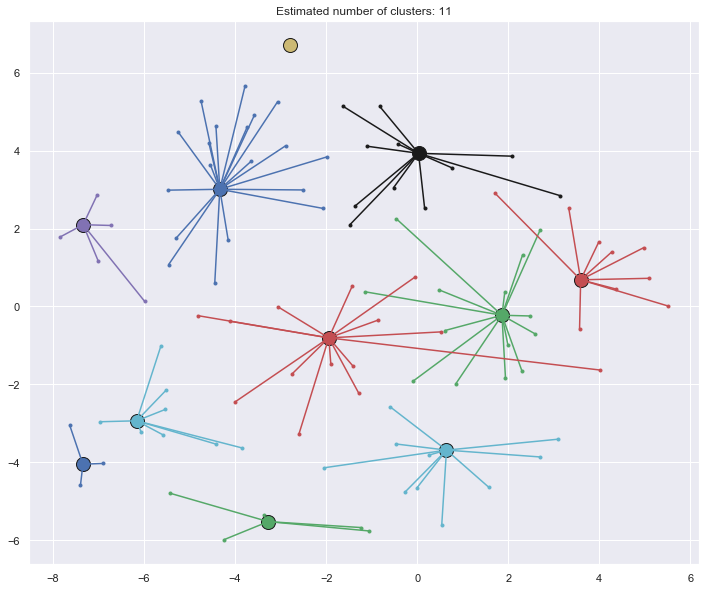

In [153]:
# using X_tsned (transformed data) instead of X

plt.close('all')
plt.figure(figsize=(12, 10))
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_2), colors):
    class_members = labels2 == k
    cluster_center = X_tsned[cluster_centers_indices2[k]]
    plt.plot(X_tsned[class_members, 0], X_tsned[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X_tsned[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col )

plt.title('Estimated number of clusters: %d' % n_clusters_2)
plt.show()

#fig.savefig('cluster-graph.png') <--this......does not work :( i can't figure out where to place "fig" w/o ruining the graph

In [154]:
clusterCountBefore = amountInCluster('ClusterBefore',n_clusters_2)
clusterCountBefore.numItems[0]

4

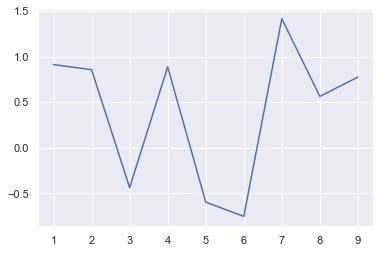

In [169]:
plt.plot(ratings, np.array(addColAverage("ClusterBefore",0)))
# print(type(addColAverage("ClusterBefore",0)))

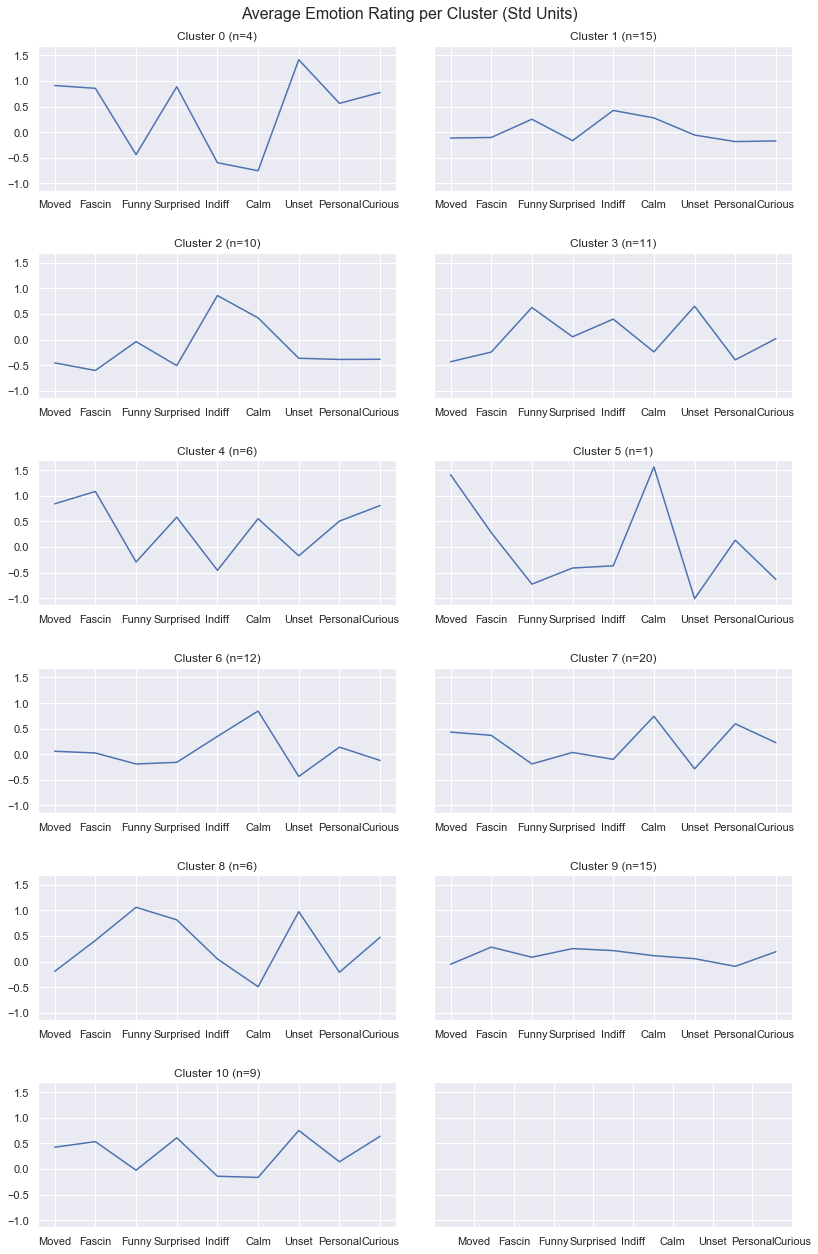

In [175]:
# plot the emotion averages of each cluster

fig, axes= plt.subplots(nrows=6, ncols=2, sharey = True, figsize=(12,18))

plt.setp(axes, xticks=[1,2,3,4,5,6,7,8,9], \
         xticklabels=["Moved","Fascin","Funny","Surprised", "Indiff","Calm","Unset","Personal","Curious"], \
#         rotation=45
        ) #adds tick marks for each emotion category
fig.suptitle("Average Emotion Rating per Cluster (Std Units)", size=16)

k = 0
for i in range(0,6):
    for j in range(0,2):
        if k<n_clusters_2:
            axes[i,j].plot(ratings, addColAverage("ClusterBefore",k))
            axes[i,j].set_title('Cluster {number} (n={amount})'.format(number = k, amount=clusterCountBefore.numItems[k]))
            k = k+1

plt.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.95)

plt.show()

fig.savefig('cluster-averages-linegraph.png')

I'm putting all the stuff I had here about combining clusters in another document - I don't think we'll need it anymore haha.

### Clustering Before t-SNE (KMeans)

Robert: not used here

In [177]:
# #fitting X (9-dim) instead of transformed X_tsned
# n_clusters_km = 13
# km = KMeans(n_clusters=n_clusters_km)

# clusteringkm = km.fit(X) 
                             
# labelskm = km.labels_

# aveEmotions['ClusterKMeans'] = labelskm

In [178]:
# # using X_tsned (transformed data) instead of X

# plt.close('all')
# plt.figure(figsize=(10, 8))
# plt.clf()

# colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
# for k, col in zip(range(n_clusters_km), colors):
#     class_members = labelskm == k
#     plt.plot(X_tsned[class_members, 0], X_tsned[class_members, 1], col + '.')

# plt.title('Estimated number of clusters: %d' % n_clusters_km)
# plt.show()

# Combining everything together!

In [179]:
## importing all rating data to recover painting names/galleries

names = pd.read_excel("ratingData-sorted.xlsx", sheet_name=1, usecols=range(0,4))
names.rename(columns = {"Unique ID":"ID"}, inplace = True)
names

,Title,Artist,Gallery,ID
0,Untitled,George Copeland Ault,1,1001
1,Pool in the Mountains,Milton Avery,1,1002
2,Simone in a Blue Bonnet (No. 1),Mary Cassatt,1,1003
3,"The Chase Homestead, Shinnecock, Long Island",William Merritt Chase,1,1004
4,Composition with Boats,Stuart Davis,1,1005
5,Formation I,Arthur Garfield Dove,1,1006
6,Junior Camp,Daniel Garber,1,1007
7,Winter Wind – Maine Coast,Marsden Hartley,1,1008
8,Mukie,Robert Henri,1,1009
9,Morning News,Francis Luis Mora,1,1010


In [182]:
#everything at once
labeledRatings = names.merge(aveEmotions, on=['ID'])
# labeledRatings = labeledRatings.drop(['ClusterAfter', 'ClusterKMeans'], axis=1)
labeledRatings = labeledRatings.merge(varsPerEmotion, on=['ID'])
labeledRatings.head()


labeledRatings.to_excel('labeledRatings.xlsx')

In [183]:
labeledRatings[(labeledRatings['ClusterBefore'] == 8)]

,Title,Artist,Gallery,ID,Moved,Fascinated,Funny,Surprised,Indifferent,Calm,...,Moved Var,Fascin Var,Funny Var,Surp Var,Indiff Var,Unset Var,Calm Var,Personal Var,Curious Var,Universal Var
4,Composition with Boats,Stuart Davis,1,1005,-0.819067,0.223562,1.482217,0.626807,0.509202,-0.070669,...,0.703871,2.770416,1.192220,1.865725,1.055493,2.525433,0.710057,0.928565,2.474610,1.952177
12,Still-life Synchromy with Nude in Yellow,Morgan Russell,1,1013,-0.159442,0.504800,0.719936,1.106089,0.158917,-0.279939,...,1.570895,3.305835,1.653232,3.275903,0.938572,1.794606,1.000084,1.108713,3.351918,2.229526
16,"Beach, Beauville",Guy Pène du Bois,1,1017,-0.337914,0.277624,1.490102,0.479166,0.333759,-0.000683,...,0.621786,1.613639,5.186650,1.280066,1.567311,2.248992,0.974394,0.843923,1.368550,1.988951
27,The Crucifixion,Martín Bernat,16,1604,0.356850,0.494097,0.188157,0.548391,-0.140123,-0.998613,...,1.360744,3.234346,2.595595,2.474896,0.644215,0.929877,2.459275,0.913268,3.217900,2.374906
29,The Arrest of Christ,Hieronymus Bosch,16,1606,0.081167,0.499141,1.549602,1.196059,-0.641634,-1.012729,...,1.382011,3.095759,3.120371,2.435656,0.381721,1.314295,2.024019,0.939119,2.910653,2.785893
91,Woman Seated,Hans Hofmann,3,3009,-0.264063,0.485777,0.933086,0.938726,0.095991,-0.574195,...,1.159402,2.062629,1.312103,1.847799,0.732009,1.553999,0.865769,0.874540,1.774399,1.654872


In [184]:
#given a cluster, creates a list of the number of paintings in each gallery
galleryList = list(["1","2","3","100","16","19","200"])
galleries = [1,2,3,100,16,19,200]

def numInGallery(clusterNum):

    numIn = np.zeros(7)
    
    sampleCluster = labeledRatings.ClusterBefore == clusterNum
    
    for i in range(0,7):
        sampleGal = labeledRatings.Gallery==galleries[i]
        numIn[i]= len(labeledRatings[sampleCluster & sampleGal])
    
    numIn = list(numIn)
    
    return numIn

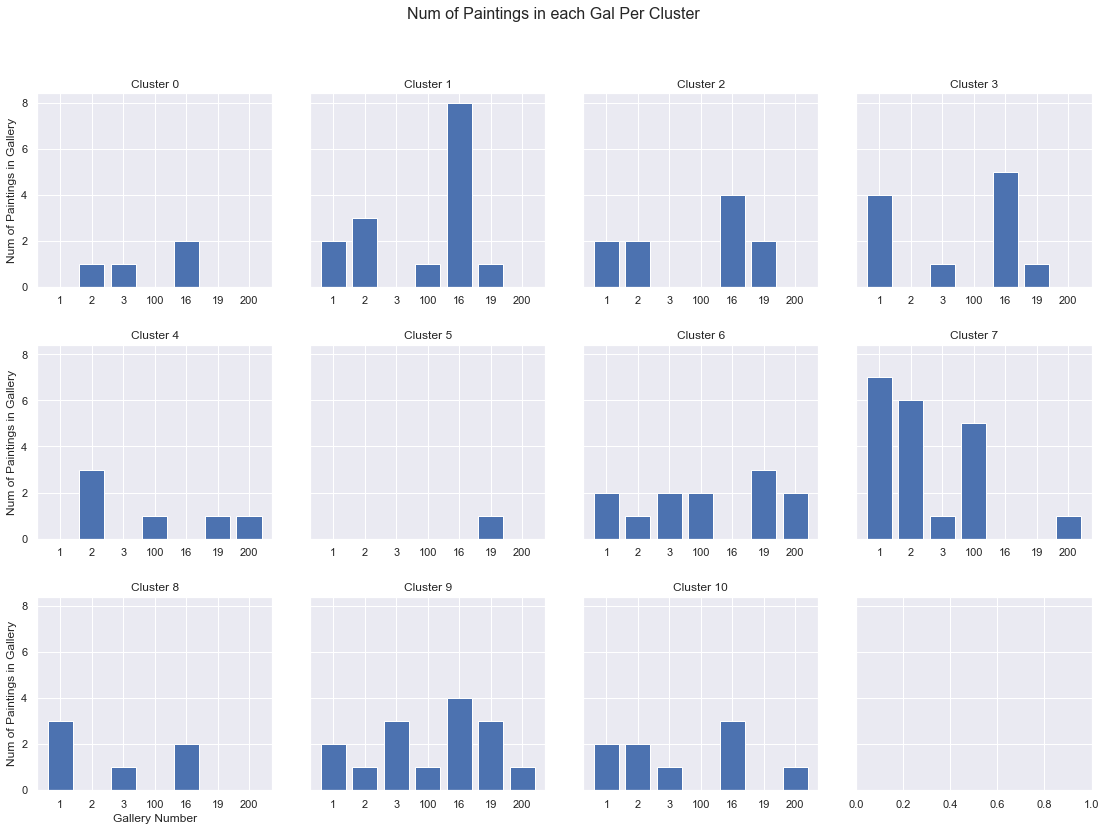

In [190]:
# for each cluster, plot num paintings in each gallery 

fig, axes= plt.subplots(nrows=3, ncols=4, sharey = True, figsize=(16,12))  #[1,2,3,100,16,19,200]

#plt.setp(axes, xticks=[1,2,3,3,4,5,6,7]) #, yticks=[1,2,3,4,5,6,7,8]) #, xticklabels=["Moved","Fascin","Funny","Surprised",
                                                        #"Indiff","Calm","Unset","Personal","Curious"]) #adds tick marks for each emotion category
fig.suptitle("Num of Paintings in each Gal Per Cluster", size=16)
numGals = [1,2,3,4,5,6,7]

k = 0
for i in range(0,3):
    for j in range(0,4):
        if k<n_clusters_2:
            axes[i,j].bar(numGals, numInGallery(k))
            axes[i,j].set_title('Cluster {number}'.format(number = k))
            axes[i,j].set_xticks([1,2,3,4,5,6,7])
            axes[i,j].set_xticklabels(galleryList)
            if j==0:
                axes[i,j].set_ylabel("Num of Paintings in Gallery")
                if i==2:
                    axes[i,j].set_xlabel("Gallery Number")
            k = k+1

plt.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.88)
fig.savefig('num-paintings-in-gal.png')

plt.show()

In [191]:
# Highest Scores

#most moving
#print(labeledRatings.iloc[(labeledRatings['Moved'].idxmax())])

#most fascinating
#print(labeledRatings.iloc[(labeledRatings['Fascinated'].idxmax())])

#most funny
#print(labeledRatings.iloc[(labeledRatings['Funny'].idxmax())])

#most surprised
#print(labeledRatings.iloc[(labeledRatings['Surprised'].idxmax())])

#most indifferent
#print(labeledRatings.iloc[(labeledRatings['Indifferent'].idxmax())])

#most calm
#print(labeledRatings.iloc[(labeledRatings['Calm'].idxmax())])

#most unsettling
#print(labeledRatings.iloc[(labeledRatings['Unsettling'].idxmax())])

#most personal
#print(labeledRatings.iloc[(labeledRatings['Personal'].idxmax())])

#most curious
#print(labeledRatings.iloc[(labeledRatings['Curious'].idxmax())])

In [192]:
#create 2 dfs: variability, ave score, and diff. sort on diff

#Fascination
fascination = labeledRatings.loc[:,['Title','Artist','Gallery','ID','Fascinated', 'Fascin Var']]
fascination['Diff'] = fascination['Fascinated'] - fascination['Fascin Var']
fascination = fascination.sort_values(by=['Diff'], ascending=False)

#Indifference
indiff = labeledRatings.loc[:,['Title','Artist','Gallery','ID','Indifferent', 'Indiff Var']]
indiff['Diff'] = indiff['Indifferent'] - indiff['Indiff Var']
indiff = indiff.sort_values(by=['Indifferent'], ascending=False) ##sorting by rating

#Unsettling
unsettled = labeledRatings.loc[:,['Title','Artist','Gallery','ID','Unsettling', 'Unset Var']]
unsettled['Diff'] = unsettled['Unsettling'] - unsettled['Unset Var']
unsettled = unsettled.sort_values(by=['Unsettling'], ascending=False) ##sorting by rating

In [193]:
#unsettled & Indifferent --> top 20 that have variance less than 2

#labeledRatings[(labeledRatings['ClusterBefore'] == 4)]
unsettledSmall = unsettled[(unsettled['Unset Var']<2)]
unsettledSmall = unsettledSmall.head(n=20)

indiffSmall = indiff[(indiff['Indiff Var']<2)]
indiffSmall = indiffSmall.head(n=20)

fascinationSmall = fascination.head(n=20)

In [194]:
unsettledSmall

,Title,Artist,Gallery,ID,Unsettling,Unset Var,Diff
51,Susanna and the Elders,de Ribera,16,1628,2.056903,1.369447,0.687456
29,The Arrest of Christ,Hieronymus Bosch,16,1606,1.723363,1.314295,0.409067
27,The Crucifixion,Martín Bernat,16,1604,1.504824,0.929877,0.574948
41,The Penitent Magdalene,Giulio Cesare Procaccini,16,1618,1.405736,0.734679,0.671057
68,Portrait of a Boy,Frank W. Duveneck,2,2005,1.142367,1.016331,0.126036
76,"Kilauea Caldera, Sandwich Islands",Jules Tavernier,2,2013,1.113181,0.897187,0.215994
22,Make Up Girl,Wayne Thiebaud,1,1023,1.109490,1.796307,-0.686817
87,Sunday Afternoon,Hughie Lee-Smith,3,3005,1.082326,1.551614,-0.469288
13,Untitled,Janet Sobel,1,1014,1.069528,1.376875,-0.307347
20,Mrs. Walter H. Richter,George Wesley Bellows,1,1021,1.019447,1.602411,-0.582964


In [195]:
#['Title','Artist','Gallery','ID']
paintingList = pd.concat([fascinationSmall, unsettledSmall, indiffSmall], sort=False)
paintingList.to_excel('paintingList.xlsx')